Best Model

In [138]:
import numpy as np

# Read in csv file for Surgical Deepnet data that is stored in path:
import pandas as pd
from sklearn import metrics
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
train_data = pd.read_csv('PYTHON_LAB_TRAIN.csv')
test_data = pd.read_csv('PYTHON_LAB_DF_TEST_2.csv')

In [139]:
train_data_1 = train_data
train_data_1['LOS'] = np.where(train_data_1['LOS'] > 5.0, 1, 0)

In [140]:
d = train_data_1.isna().any()

cols_to_ignore = ['AGE_ON_CONTACT_DATE', 'BP_SYSTOLIC', 'PULSE', 'BP_DIASTOLIC']
d[cols_to_ignore] = False

train_data_1 = train_data_1.loc[:, ~d]

In [141]:
train_data_1['PROC_DATE'] = pd.to_datetime(train_data_1['PROC_DATE'])
train_data_1['SCHED_START_DT_TM'] = pd.to_datetime(train_data_1['SCHED_START_DT_TM'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [142]:
((train_data_1['SCHED_START_DT_TM'][1] - train_data_1['PROC_DATE'][1]).seconds)/3600

#train_data_1['Delay'] = ((train_data_1['SCHED_START_DT_TM'] - train_data_1['PROC_DATE']).seconds)/3600
train_data_1['Delay'] = (pd.to_datetime(train_data_1['SCHED_START_DT_TM']) - pd.to_datetime(train_data_1['PROC_DATE'])).astype('timedelta64[h]') / 3600.0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [143]:
train_data_1 = train_data_1.drop(columns=['PROC_DATE', 'SCHED_START_DT_TM', 'CREATE_DT_TM'])

In [144]:
train_data_1['SCHED_SURG_AREA'] = train_data_1['SCHED_SURG_AREA'].astype('category')
train_data_1['SCHED_SURG_AREA'] = train_data_1['SCHED_SURG_AREA'].cat.codes

train_data_1['SCHED_SURG_PROC_CD'] = train_data_1['SCHED_SURG_PROC_CD'].astype('category')
train_data_1['SCHED_SURG_PROC_CD'] = train_data_1['SCHED_SURG_PROC_CD'].cat.codes

train_data_1['SCHED_HOSPITAL'] = train_data_1['SCHED_HOSPITAL'].astype('category')
train_data_1['SCHED_HOSPITAL'] = train_data_1['SCHED_HOSPITAL'].cat.codes

In [145]:
train_data_1 = train_data_1.drop(columns=['LOS'])

In [146]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Train the imputor on the df dataset
imputer = imputer.fit(train_data_1)

# Apply the imputer to the df dataset
imputed_df = imputer.transform(train_data_1.values)

new_df = pd.DataFrame(imputed_df)

In [147]:
new_df = pd.concat([new_df, train_data['LOS']], axis=1)

In [148]:
# Again, we split the data into training and testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(new_df.drop(columns = ['LOS']), 
                                                    new_df['LOS'], 
                                                    test_size=0.2, 
                                                    random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1)

In [149]:
import xgboost as xgb

print(x_train.shape, x_val.shape, x_test.shape)

(51200, 8) (12800, 8) (16000, 8)


In [126]:
dtrain = xgb.DMatrix(data = x_train, label = y_train)
dval = xgb.DMatrix(data = x_val, label = y_val)
dtest = xgb.DMatrix(data = x_test, label = y_test)

Series.base is deprecated and will be removed in a future version


In [102]:
param = {'booster': 'gbtree',
 'colsample_bytree': 0.8500000000000001,
 'objective':'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 0.39,
 'max_depth': 80,
 'maximize': 0,
 'min_child_weight': 75.0,
 'n_thread': 0,
 'n_estimators' : 1000,
 'reg_alpha': 50.0,
 'reg_lambda': 1.22711439376566,
 'scale_pos_weight': 6.586573078664614,
 'subsample': 1.0,
 'verbose': 0,
 'gamma' : 10,
        }

In [103]:
# specify validations set to watch performance
watchlist = [(dtrain, 'train'), (dval, 'eval')]
num_round = 20000 #This is another hyperparameter of sorts
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds = 15)

[0]	train-auc:0.762837	eval-auc:0.749802
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 15 rounds.
[1]	train-auc:0.776162	eval-auc:0.761415
[2]	train-auc:0.793544	eval-auc:0.777182
[3]	train-auc:0.8012	eval-auc:0.783239
[4]	train-auc:0.804007	eval-auc:0.784464
[5]	train-auc:0.805132	eval-auc:0.785115
[6]	train-auc:0.813251	eval-auc:0.791133
[7]	train-auc:0.815655	eval-auc:0.79341
[8]	train-auc:0.818654	eval-auc:0.796839
[9]	train-auc:0.820715	eval-auc:0.799326
[10]	train-auc:0.821235	eval-auc:0.799752
[11]	train-auc:0.821701	eval-auc:0.800446
[12]	train-auc:0.821967	eval-auc:0.800537
[13]	train-auc:0.822186	eval-auc:0.800526
[14]	train-auc:0.822354	eval-auc:0.800837
[15]	train-auc:0.826452	eval-auc:0.804999
[16]	train-auc:0.826582	eval-auc:0.804996
[17]	train-auc:0.827746	eval-auc:0.80601
[18]	train-auc:0.827755	eval-auc:0.806017
[19]	train-auc:0.828406	eval-auc:0.806563
[20]	train-auc:0.828442	eval-auc:

In [104]:
mort_train_w_preds = x_train
mort_train_w_preds['xgb_probs'] = bst.predict(dtrain)

mort_test_w_preds = x_test
mort_test_w_preds['xgb_probs'] = bst.predict(dtest)

In [105]:
y = y_test
scores = mort_test_w_preds['xgb_probs']

fpr, tpr, thresholds = metrics.roc_curve(y_train, mort_train_w_preds['xgb_probs'])
metrics.auc(fpr, tpr)

0.8329970253488329

In [106]:
fpr, tpr, thresholds = metrics.roc_curve(y, scores)
metrics.auc(fpr, tpr)

0.8126190938578574

Re-tuning using Hyper Opt

In [19]:
import hyperopt as hp
from hyperopt import Trials,fmin,STATUS_OK

In [22]:
# Sets the space to search over and the prior probabilities over the search space 
xgb_space = {
    'booster': hp.hp.choice('booster',  ['gbtree', 'dart']),
    'eta': hp.hp.loguniform('learning_rate', 0, 1),
    'max_depth':hp.hp.choice('max_depth', np.arange(3, 300,1, dtype=int)),
    'subsample':hp.hp.quniform('subsample',0.5,1.0,0.05),
    'colsample_bytree':hp.hp.quniform('colsample_bytree',0.5,1.0,0.05),
    'min_child_weight':hp.hp.quniform('min_child_weight', 100, 1000,100),
    'lambda': hp.hp.uniform('reg_alpha', 0.0, 1000.0),
    'alpha': hp.hp.uniform('reg_lambda', 0.0, 1000.0),
    'scale_pos_weight': hp.hp.uniform('scale_pos_weight', 6.0, 10.0),
    'eval_metric' : hp.hp.choice('eval_metric', ['auc']),
    'n_thread': hp.hp.choice('n_thread', [-1]),
    'verbose' : hp.hp.choice('verbose', [-1]),
    'maximize' : hp.hp.choice('maximize', ['TRUE'])
    }

In [23]:
def objective_m(params, n_folds=5):


    model = xgb.cv(params = params,
              dtrain = dtrain,
              num_boost_round = 10,
              early_stopping_rounds = 10,
             nfold = n_folds)
  
    
  
    # returns the best average loss on validation set 
    
    loss = 1 - max(model['test-auc-mean'])
    return loss


bayes_trials = Trials()
MAX_EVALS = 1000 # this controls the runtime 

xgb_best_m = fmin(fn = objective_m, space = xgb_space, algo = hp.tpe.suggest, 
max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 1000/1000 [55:56<00:00,  3.36s/trial, best loss: 0.19343860000000002]


In [24]:
xgb_best_m

{'booster': 1,
 'colsample_bytree': 0.6000000000000001,
 'eval_metric': 0,
 'learning_rate': 1.0202353005040365,
 'max_depth': 30,
 'maximize': 0,
 'min_child_weight': 200.0,
 'n_thread': 0,
 'reg_alpha': 523.8911857997225,
 'reg_lambda': 0.24495056502407442,
 'scale_pos_weight': 9.880197773025346,
 'subsample': 1.0,
 'verbose': 0}

In [25]:
param = {'booster': 'gbtree',
 'colsample_bytree': 0.6000000000000001,
 'objective':'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 1.0202353005040365,
 'max_depth': 30,
 'maximize': 0,
 'min_child_weight': 200.0,
 'n_thread': 0,
 'reg_alpha': 523.8911857997225,
 'reg_lambda': 0.24495056502407442,
 'scale_pos_weight': 9.880197773025346,
 'subsample': 1.0,
 'verbose': 0
        }

In [27]:
# specify validations set to watch performance
watchlist = [(dtrain, 'train'), (dval, 'eval')]
num_round = 20000 #This is another hyperparameter of sorts
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds = 10)

[0]	train-auc:0.624045	eval-auc:0.61722
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.719649	eval-auc:0.711569
[2]	train-auc:0.741243	eval-auc:0.73157
[3]	train-auc:0.762986	eval-auc:0.752241
[4]	train-auc:0.764161	eval-auc:0.754451
[5]	train-auc:0.76747	eval-auc:0.757113
[6]	train-auc:0.768116	eval-auc:0.757118
[7]	train-auc:0.768772	eval-auc:0.757638
[8]	train-auc:0.772807	eval-auc:0.76204
[9]	train-auc:0.773629	eval-auc:0.763009
[10]	train-auc:0.774326	eval-auc:0.763344
[11]	train-auc:0.774326	eval-auc:0.763344
[12]	train-auc:0.774326	eval-auc:0.763344
[13]	train-auc:0.774326	eval-auc:0.763344
[14]	train-auc:0.774326	eval-auc:0.763344
[15]	train-auc:0.774326	eval-auc:0.763344
[16]	train-auc:0.774326	eval-auc:0.763344
[17]	train-auc:0.774326	eval-auc:0.763344
[18]	train-auc:0.774326	eval-auc:0.763344
[19]	train-auc:0.774326	eval-auc:0.763344
[20]	train-auc:0.774326	eval-auc:

In [28]:
mort_train_w_preds = x_train
mort_train_w_preds['xgb_probs'] = bst.predict(dtrain)

mort_test_w_preds = x_test
mort_test_w_preds['xgb_probs'] = bst.predict(dtest)

In [29]:
y = y_test
scores = mort_test_w_preds['xgb_probs']

fpr, tpr, thresholds = metrics.roc_curve(y_train, mort_train_w_preds['xgb_probs'])
metrics.auc(fpr, tpr)

0.7743257660591076

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(y, scores)
metrics.auc(fpr, tpr)

0.7656803674421822

In [67]:
param = {'booster': 'gbtree',
 'colsample_bytree': 0.6000000000000001,
 'objective':'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 1.0202353005040365,
 'max_depth': 100,
 'maximize': 0,
 'min_child_weight': 200.0,
 'n_thread': 0,
 'reg_alpha': 120.8911857997225,
 'reg_lambda': 0.24495056502407442,
 'scale_pos_weight': 9.880197773025346,
 'subsample': 1.0,
 'verbose': 0
        }

In [68]:
# specify validations set to watch performance
watchlist = [(dtrain, 'train'), (dval, 'eval')]
num_round = 20000 #This is another hyperparameter of sorts
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds = 10)

[0]	train-auc:0.692446	eval-auc:0.680238
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.780876	eval-auc:0.769575
[2]	train-auc:0.789856	eval-auc:0.775506
[3]	train-auc:0.793543	eval-auc:0.777438
[4]	train-auc:0.796742	eval-auc:0.780187
[5]	train-auc:0.798104	eval-auc:0.780501
[6]	train-auc:0.798951	eval-auc:0.780342
[7]	train-auc:0.799224	eval-auc:0.780182
[8]	train-auc:0.809923	eval-auc:0.790581
[9]	train-auc:0.813548	eval-auc:0.793652
[10]	train-auc:0.81505	eval-auc:0.794261
[11]	train-auc:0.815507	eval-auc:0.794878
[12]	train-auc:0.816144	eval-auc:0.794843
[13]	train-auc:0.816615	eval-auc:0.795373
[14]	train-auc:0.816839	eval-auc:0.795302
[15]	train-auc:0.818061	eval-auc:0.796604
[16]	train-auc:0.818286	eval-auc:0.795848
[17]	train-auc:0.8185	eval-auc:0.796213
[18]	train-auc:0.81896	eval-auc:0.796675
[19]	train-auc:0.819396	eval-auc:0.797041
[20]	train-auc:0.819576	eval-auc:

In [69]:
mort_train_w_preds = x_train
mort_train_w_preds['xgb_probs'] = bst.predict(dtrain)

mort_test_w_preds = x_test
mort_test_w_preds['xgb_probs'] = bst.predict(dtest)

In [70]:
y = y_test
scores = mort_test_w_preds['xgb_probs']

fpr, tpr, thresholds = metrics.roc_curve(y_train, mort_train_w_preds['xgb_probs'])
metrics.auc(fpr, tpr)

0.8295141388609064

In [71]:
fpr, tpr, thresholds = metrics.roc_curve(y, scores)
metrics.auc(fpr, tpr)

0.8045122508455499

In [127]:
param = {'booster': 'gbtree',
 'colsample_bytree': 0.8500000000000001,
 'objective':'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 0.39,
 'max_depth': 80,
 'maximize': 0,
 'min_child_weight': 75.0,
 'n_thread': 0,
 'n_estimators' : 1000,
 'reg_alpha': 50.0,
 'reg_lambda': 1.22711439376566,
 'scale_pos_weight': 6.586573078664614,
 'subsample': 1.0,
 'verbose': 0,
 'gamma' : 10,
        }

In [128]:
# specify validations set to watch performance
watchlist = [(dtrain, 'train'), (dval, 'eval')]
num_round = 20000 #This is another hyperparameter of sorts
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds = 15)

[0]	train-auc:0.762837	eval-auc:0.749802
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 15 rounds.
[1]	train-auc:0.776162	eval-auc:0.761415
[2]	train-auc:0.793544	eval-auc:0.777182
[3]	train-auc:0.8012	eval-auc:0.783239
[4]	train-auc:0.804007	eval-auc:0.784464
[5]	train-auc:0.805132	eval-auc:0.785115
[6]	train-auc:0.813251	eval-auc:0.791133
[7]	train-auc:0.815655	eval-auc:0.79341
[8]	train-auc:0.818654	eval-auc:0.796839
[9]	train-auc:0.820715	eval-auc:0.799326
[10]	train-auc:0.821235	eval-auc:0.799752
[11]	train-auc:0.821701	eval-auc:0.800446
[12]	train-auc:0.821967	eval-auc:0.800537
[13]	train-auc:0.822186	eval-auc:0.800526
[14]	train-auc:0.822354	eval-auc:0.800837
[15]	train-auc:0.826452	eval-auc:0.804999
[16]	train-auc:0.826582	eval-auc:0.804996
[17]	train-auc:0.827746	eval-auc:0.80601
[18]	train-auc:0.827755	eval-auc:0.806017
[19]	train-auc:0.828406	eval-auc:0.806563
[20]	train-auc:0.828442	eval-auc:

In [129]:
import shap
import lime

In [130]:
from matplotlib.pyplot import figure
figure(num=None, figsize = (20,20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [131]:
xgb_shap_explainer = shap.TreeExplainer(bst)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [153]:
train_data_1.columns

Index(['SCHED_SURG_AREA', 'SCHED_HOSPITAL', 'SCHED_SURG_PROC_CD',
       'AGE_ON_CONTACT_DATE', 'BP_SYSTOLIC', 'BP_DIASTOLIC', 'PULSE', 'Delay'],
      dtype='object')

In [154]:
x_train.columns = ['SCHED_SURG_AREA', 'SCHED_HOSPITAL', 'SCHED_SURG_PROC_CD',
       'AGE_ON_CONTACT_DATE', 'BP_SYSTOLIC', 'BP_DIASTOLIC', 'PULSE', 'Delay']

In [156]:
x_test.columns = ['SCHED_SURG_AREA', 'SCHED_HOSPITAL', 'SCHED_SURG_PROC_CD',
       'AGE_ON_CONTACT_DATE', 'BP_SYSTOLIC', 'BP_DIASTOLIC', 'PULSE', 'Delay']

In [157]:
xgb_shap_vals_train = xgb_shap_explainer.shap_values(x_train)

In [158]:
xgb_shap_vals_test = xgb_shap_explainer.shap_values(x_test)

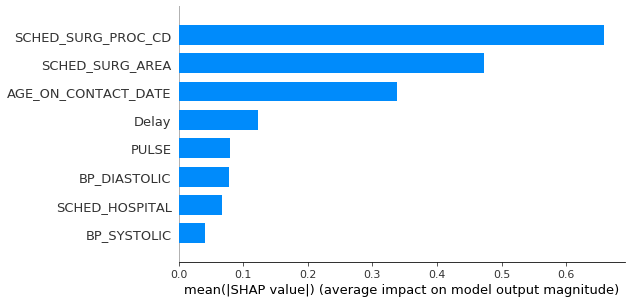

In [159]:
shap.summary_plot(xgb_shap_vals_train, x_train, plot_type="bar")

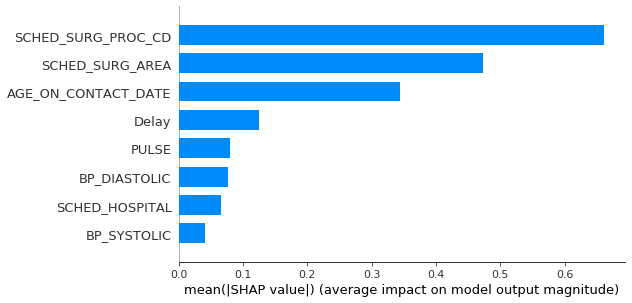

In [160]:
shap.summary_plot(xgb_shap_vals_test, x_test, plot_type="bar")

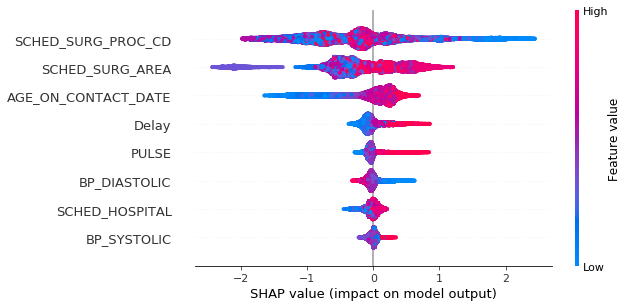

In [161]:
shap.summary_plot(xgb_shap_vals_train, x_train)

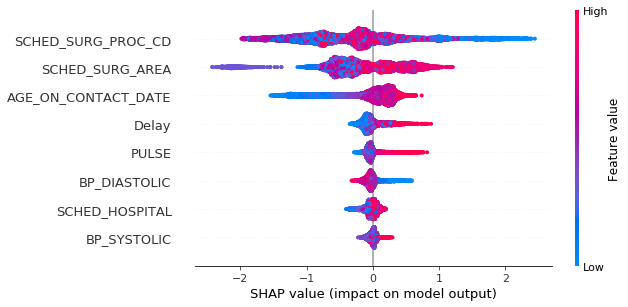

In [162]:
shap.summary_plot(xgb_shap_vals_test, x_test)

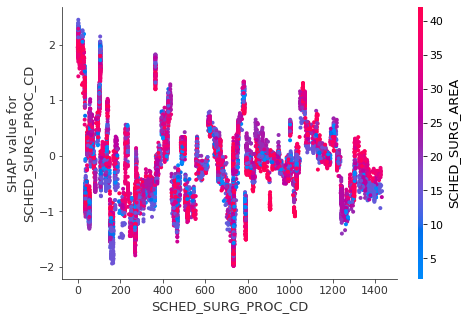

In [163]:
shap.initjs()
shap.dependence_plot("SCHED_SURG_PROC_CD", xgb_shap_vals_test, x_test)